In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

from PIL import Image, ImageOps

In [2]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_sagittal_images_jpeg95')

In [3]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv')).set_index('UID')
bbox_df

,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.9940,1,139,148,339,2.666667,0.234375,0.625,0.0,259,297.23186,115.53983,85.18228,66.52623,140
1.2.826.0.1.3680043.9940,1,140,147,341,2.666667,0.234375,0.625,0.0,259,298.00000,117.00000,86.00000,61.00000,141
1.2.826.0.1.3680043.9940,1,141,148,341,2.666667,0.234375,0.625,0.0,259,298.00000,119.00000,87.00000,58.00000,142


In [4]:
df = pd.DataFrame()

def make_df(UID, intersect, start_index, end_index, ymin, ymax, aspect):
    # print(intersect)
    # print(start_index, end_index, y_min, ymax)
    new_df = pd.DataFrame()
    # print(len(intersect))
    print(intersect[len(intersect) // 2])
    new_df['sagittal_index'] = np.arange(intersect[len(intersect) // 2], intersect[len(intersect) // 2]+1)
    new_df[['UID','xmin','ymin','xmax','ymax', 'aspect']] = [UID, ymin, start_index * aspect, ymax, end_index * aspect, aspect]

    # print(new_df)
    return new_df

for UID in bbox_df.index.unique():
    # UID = '1.2.826.0.1.3680043.11300'
    patient_df = bbox_df.loc[UID].sort_values(by='axial_index')
    # print(patient_df)
    aspect = patient_df.iloc[0].aspect
    
    intersect_list = []

    intersect = np.arange(512)
    start_slice = None
    end_slice = None
    y_min = None
    y_max = None

    for i in range(len(patient_df)):
        s = patient_df.iloc[i]
        if i == 0:
            start_slice = s.axial_index
            y_min = s.y
            y_max = s.y + s.height

        if s.axial_index == (start_slice + i):
            x_array = np.arange(int(s.x), int(s.x + s.width))
            intersect = np.intersect1d(intersect, x_array)
            y_min = np.min((y_min, s.y))
            y_max = np.max((y_max, s.y + s.height))
            end_slice = s.axial_index
        else:
            # make_df(intersect, start_slice, end_slice, y_min, y_max)
            break
            # end previous box


            # reset
            intersect = np.arange(int(s.x), int(s.x + s.width))
            start_slice = s.axial_index
            y_min = s.y
            y_max = s.y + s.height
            end_slice = s.axial_index

    if len(intersect) > 0:
        new_df = make_df(UID, intersect, start_slice, end_slice, y_min, y_max, aspect)

        df = pd.concat((df, new_df))
# patient_df

222
267
144
238
200
192
310
288
150
160
282
286
220
250
204
293
254
330
243
233
268
262
235
253
233
256
315
253
165
250
310
253
258
251
323
257
320
254
273
373
287
261
274
199
216
188
324
204
304
164
240
236
301
243
317
320
327
185
261
241
251
252
255
235
220
340
252
290
241
259
280
348
250
198
209
293
312
169
183
271
221
145
180
254
268
235
242
171
226
284
257
228
233
266
277
215
238
279
243
182
272
269
181
254
267
326
248
313
275
308
259
265
261
161
215
261
260
179
279
233
314
254
247
251
253
180
288
171
255
284
221
240
272
289
311
162
309
275
309
193
237
263
190
288
265
305
166
276
243
262
168
245
313
288
285
242
282
239
227
271
162
259
299
313
257
357
392
257
345
133
283
243
268
283
255
255
223
254
243
262
283
273
256
215
251
262
222
134
167
256
197
318
266
236
211
185
293
353
272
244
317
303
235
237
234
211
266
318
260
250
275
215
248
214
226
186
127
116
248
190
227
211
346


In [5]:
df = df.set_index('UID')
df

,sagittal_index,xmin,ymin,xmax,ymax,aspect
UID,,,,,,
1.2.826.0.1.3680043.10051,222,212.24727,324.923397,282.06546,361.846510,2.461541
1.2.826.0.1.3680043.10579,267,244.96552,234.666667,287.52072,240.761905,3.047619
1.2.826.0.1.3680043.10678,144,252.58667,202.298851,291.00000,220.689655,3.065134
1.2.826.0.1.3680043.10697,238,112.71642,467.153285,163.77748,493.313869,3.737226
1.2.826.0.1.3680043.10815,200,318.77395,265.882353,403.28567,301.176471,2.352941
...,...,...,...,...,...,...
1.2.826.0.1.3680043.8511,248,254.41648,294.345753,316.70104,314.598901,1.350210
1.2.826.0.1.3680043.8519,190,137.04089,128.503872,172.63061,141.102291,2.519684
1.2.826.0.1.3680043.8693,227,255.29378,225.881572,351.15385,252.772236,5.378133


sagittal_index    253.000000
xmin              126.675860
ymin              436.613497
xmax              279.393090
ymax              505.717791
aspect              3.141104
Name: 1.2.826.0.1.3680043.1309, dtype: float64


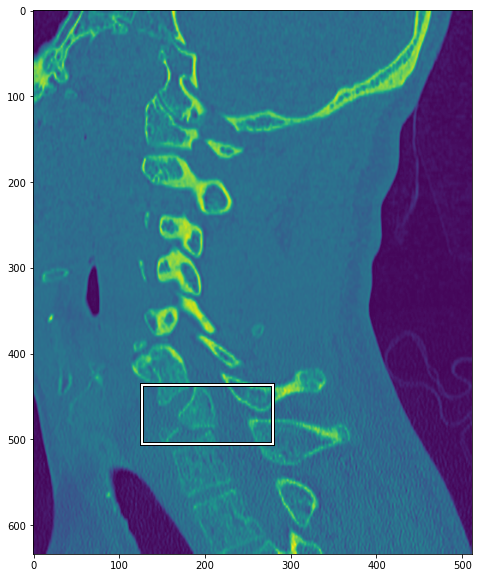

In [6]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()
    
    
s = df.iloc[27]
print(s)
image = Image.open(os.path.join(IMAGES_DIR, s.name, f'{int(s.sagittal_index)}.jpeg'))
bbox = list(s[['xmin','ymin','xmax','ymax']])

# crop_box = s[['xmin','ymin','xmax','ymax']]
# image, bbox = crop_image(image, bbox, crop_box)
show_image(image, bbox)

In [7]:
df.to_csv(os.path.join(DATA_DIR, 'sagittal_bbox.csv'))